# Introduction to MODFLOW and FloPy
**Author**: Noah Athens. **Date**: April 10th, 2018


This short tutorial will show you how to build a simple groundwater model using MODFLOW-2005 and FloPy. Refer to the README for installation instructions. Additional tutorials available [here](https://modflowpy.github.io/flopydoc/tutorials.html) 

We will use MODFLOW to solve for the hydraulic head distribution in a single layer, confined aquifer with a pumping well. 

MODFLOW uses the finite-difference method to solve the groundwater flow equation:

$\frac{\partial}{\partial x}(K_{xx}(x,y,z)\frac{\partial h}{\partial x}) + \frac{\partial}{\partial y}(K_{yy}(x,y,z)\frac{\partial h}{\partial y}) + \frac{\partial}{\partial z}(K_{zz}(x,y,z)\frac{\partial h}{\partial z}) - W(x,y,z) = S_s(x,y,z)\frac{\partial h}{\partial t}$

$W(x,y,z) =$ source term e.g. wells; 
$K_{xx} =$ hydraulic conductivity in x-dir at cell x,y,z; 
$S_s(x,y,z)=$ specific storage at cell x,y,z


## 1 - Import packages ##

First, run the cell below to import all the packages that you will need during this assignment. 
- [numpy](http://www.numpy.org/) is the standard package for scientific computing with Python
- [flopy](https://github.com/modflowpy/flopy) creates, runs, and post-processes MODFLOW models
- [matplotlib](https://matplotlib.org/) is a common library for making plots

In [1]:
import numpy as np
import flopy
import flopy.utils.binaryfile as bf
import matplotlib.pyplot as plt
%matplotlib inline

## 2 - Define the model grid

**MODFLOW tips**
- MODFLOW uses the array format (layer, row, column).
- MODFLOW requires consistent units of length and time. For example, you can use meters, centimeters, or feet for length so long as every parameter with measurements of length uses that unit. I will use units of meters and days.


In [2]:
# Define grid dimensions and cell size
nlay = 1
nrow = 100
ncol = 100
lx = 100. # cell size in x (meters)
ly = 100. # cell size in y
ztop = 500.
zbot = 0. # depth of the model in z 
delr = lx / ncol
delc = ly / nrow
delv = (ztop - zbot) / nlay
botm = np.linspace(ztop, zbot, nlay + 1)

# Create the ibound array (values > 0 are active in the simulation)
ibound = np.ones((nlay, nrow, ncol), dtype=np.int32)
print ibound.shape

(1L, 100L, 100L)


## 3 - Define study type

For time-dependent simulations, you must define time step parameters. Here we will define a stationary solution followed by 7 days time-dependent simulation divided into 100 time steps. The stationary solution will simulate the pre-pumping phase, and the time-dependent solution will simulate the pumping phase. 

In [3]:
# Time step parameters
nper = 2 # number of stress periods
perlen = [1, 7] # stress period lengths
nstp = [1, 100] # time steps per period
steady = [True, False]

## 4 - Define layer properties

Hydraulic Conductivity and Specific Storage can both be functions in space (X, Y, Z). In this example, we will use constant values. In other problems, you will generate spatially varying fields for these parameters. 

In [4]:
hcon = 1e-1 * np.ones((nlay, nrow, ncol)) # hydraulic conductivity meters/day
hcon_vert = hcon # vertical hydraulic conductivity
ss = 1e-4 * np.ones((nlay, nrow, ncol)) # specific storage 1 / meters

## 5 - Define initial conditions and boundary conditions

MODFLOW requires an initial guess to the head distribution. It's usually not that important, but it'll help the solver if the starting heads are close to the final heads. 

In [5]:
# Starting heads
initial_head = 100.
strt = initial_head * np.ones((nlay, nrow, ncol), dtype=np.float32) # starting heads = 100

# Conductance into and out of the model (at the boundaries)
headleft = initial_head + 5 # Impose hydraulic gradient over the model
headright = initial_head - 5
boundary = []

for il in range(nlay):
    for ir in range(nrow):
        condleft = hcon[il, ir, 0] * (headleft - zbot) * delc
        condright = hcon[il, ir, ncol - 1] * (headright - zbot) * delc
        boundary.append([il, ir, 0, headleft, condleft])
        boundary.append([il, ir, ncol - 1, headright, condright])

ghb_stress_period_data = {0: boundary, 1: boundary}


## 6 - Define source terms - e.g. a pumping well

Recall that in this problem we will first solve the steady state solution without pumping, and then we will start pumping in the time-dependent solutions (second stress period). 

In [6]:
pumping_rate = -1000 # production is negative, injection is positive
wel_sp1 = [[0, 25, 25, 0.]] # Well is located at cell (0, 25, 25). No pumping during the steadystate solutions
wel_sp2 = [[0, 25, 25, pumping_rate]]
wel_stress_period_data = {0:wel_sp1, 1:wel_sp2}
oc_stress_period_data = {} # Output control
for kper in range(nper):
    for kstp in range(nstp[kper]):
        oc_stress_period_data[(kper, kstp)] = ['save head', 'save drawdown', 'save budget']

## 7 - Define flopy objects

MODFLOW-2005 executable needs to be in your path or the path needs to be given in the function below

laytyp = 0 indicates confined aquifer; 
layvka = 0 indicates vertical hydraulic conductivity is as specified (not 0 indicates vka is the ratio of vertical to hydraulic conductivity 

In [7]:
modelname = 'my_cool_sim'

# Model object
mf = flopy.modflow.Modflow(modelname, exe_name='mf2005') # Windows users
#mf = flopy.modflow.Modflow(modelname,namefile_ext='nam',version='mf2005', exe_name='/Users/*/*/*/*/mf2005') # Mac users

# Discretization object
dis = flopy.modflow.ModflowDis(mf, nlay, nrow, ncol, delr=delr, delc=delc,
                                   top=ztop, botm=botm[1:],nper=nper, perlen=perlen, nstp=nstp, steady=steady)
# Basic package object
bas = flopy.modflow.ModflowBas(mf, ibound=ibound, strt=strt)

# Layer package object
lpf = flopy.modflow.ModflowLpf(mf, hk=hcon, vka=hcon_vert, ss = ss, laytyp=0, layvka=0, ipakcb=53)

# Time dependent solver package
pcg = flopy.modflow.ModflowPcg(mf)

# General Head Boundary package
ghb = flopy.modflow.ModflowGhb(mf, stress_period_data=ghb_stress_period_data)

# Well package
wel = flopy.modflow.ModflowWel(mf, stress_period_data=wel_stress_period_data)

# Output control
oc = flopy.modflow.ModflowOc(mf, stress_period_data=oc_stress_period_data, compact=True)

## 8 - Write input files and run

In [8]:
mf.write_input()
success, mfoutput = mf.run_model(silent=True, pause=False, report=True)
if not success:
    raise Exception('MODFLOW did not terminate normally.')

## 9 - Read output files

In [9]:
headobj = bf.HeadFile(modelname + '.hds')
times = headobj.get_times()

before_pumping = np.squeeze(headobj.get_data(totim = times[0])) # squeeze to remove z dimension in 2D model
after_pumping = np.squeeze(headobj.get_data(totim = times[-1]))
time_series_at_well = headobj.get_ts((0, 25, 25))

## 10 - Make some basic plots using matplotlib

<function matplotlib.pyplot.tight_layout>

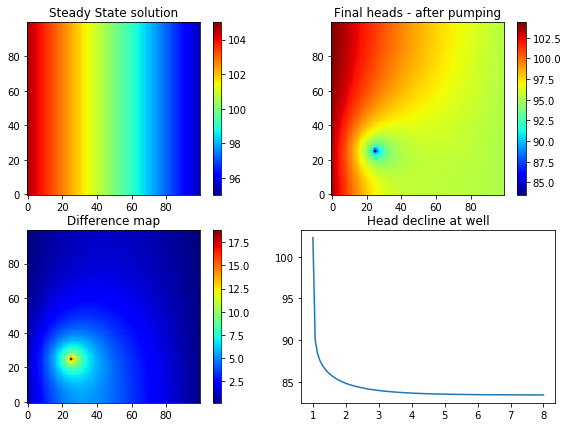

In [10]:
fig = plt.figure(figsize=(10, 7))
fig.add_subplot(2,2,1)
plt.imshow(before_pumping, cmap='jet', origin='lower', vmin=95, vmax=105)
plt.title('Steady State solution')
plt.colorbar()

fig.add_subplot(2,2,2)
plt.imshow(after_pumping, cmap='jet', origin='lower')
plt.title('Final heads - after pumping')
plt.colorbar()

fig.add_subplot(2,2,3)
plt.imshow(np.abs(before_pumping - after_pumping), cmap='jet', origin='lower')
plt.title('Difference map')
plt.colorbar()

fig.add_subplot(2, 2, 4)
plt.plot(time_series_at_well[:,0], time_series_at_well[:,1], '-')
plt.title('Head decline at well')
plt.tight_layout


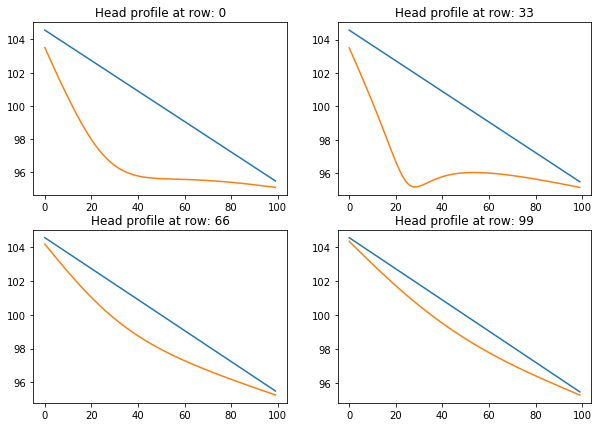

In [11]:
rows = np.linspace(0, nrow - 1, 4, dtype='int32') # For plotting profiles
fig = plt.figure(figsize=(10, 7))
for i in range(4):
    fig.add_subplot(2, 2, i + 1)
    plt.plot(before_pumping[rows[i], :], '-')
    plt.plot(after_pumping[rows[i], :], '-')
    plt.title('Head profile at row: ' + str(rows[i]))